# Competition: Modulation format classification

#### Solution using simple binary classification based on quadrature energies

Enter your team name here:

In [1]:
# Bevore you start, please enter your team name!
team_name = 'REFERENCE_BINARY_CLASSIFICATION'

The main code starts here...

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle

Helper code that computes the the classification error rate, i.e. $\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y})$, an estimate of the error probability. The classification is obtained from $N$ pairs $(\boldsymbol{x}_i, y_i)$, $i=1,\ldots, N$ and the corresponding estimates $\hat{y}_i = f(\boldsymbol{x}_i)$ as follows
$$
\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y}) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{\{f(\boldsymbol{x}_i) \neq y_i\}}
$$
where $\mathbb{1}_{\{E\}}$ is the indicator function, which returns 1 if the event $E$ is true and 0 otherwise

In [3]:
# helper function to compute the classification error rate.
def CER(predictions, labels):
    """Calculates the classification error rate."""
    return (np.sum(predictions != labels) / len(predictions))

This is a helper function that double-checks if the data is correct and carries out some sanity-checks.

In [4]:
# Checks if the data you upload has the correct type/form
def check_predictions(test_data, predictions, valid_values):
    """Chcecks if predicitions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')
    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')
    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')
    all_values_valid = True
    for i in range(len(predictions)):
        if (predictions[i] not in valid_values):
            print('All values of "predictions" have to be in "valid data".')
            all_values_valid = False
            break
    if all_values_valid:
        print('Predictions are valid values.')

## Task 1: Distinguish between BPSK and QPSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. 

Show the classification error for the validation set for each SNR point separately.

Load datasets. They are stored as a pickle file.

The dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

In [5]:
# Download data sets if they are not available
from os.path import exists
import urllib.request
    
if not exists('MLOC_Competition_2023_task1_dataset_train.pkl'):
    print('Downloading data set file 1/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_train.pkl', 'MLOC_Competition_2023_task1_dataset_train.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_dataset_valid.pkl'):
    print('Downloading data set file 2/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_valid.pkl', 'MLOC_Competition_2023_task1_dataset_valid.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_test_data.pkl'):
    print('Downloading data set file 3/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_test_data.pkl', 'MLOC_Competition_2023_task1_test_data.pkl')        
    print('done')

In [6]:
# Load training dataset
with open('MLOC_Competition_2023_task1_dataset_train.pkl', "rb") as f:
    X_train_task_1 = pickle.load(f)
    y_train_task_1 = pickle.load(f)
    SNR_train_task_1 = pickle.load(f)
    modulation_formats_task_1 = pickle.load(f)
    SNRs_task_1 = pickle.load(f)
    
# Load validation dataset
with open('MLOC_Competition_2023_task1_dataset_valid.pkl', "rb") as f:
    X_valid_task_1 = pickle.load(f)
    y_valid_task_1 = pickle.load(f)
    SNR_valid_task_1 = pickle.load(f) 
    
# Load test data
with open('MLOC_Competition_2023_task1_test_data.pkl', "rb") as f:
    X_test_task_1 = pickle.load(f)

Print modulation formats ans SNR values which are used:

In [7]:
print('Modulation formats: ', modulation_formats_task_1)
print('SNR values: ', SNRs_task_1)

Modulation formats:  ['BPSK', 'QPSK']
SNR values:  [-10  -8  -6  -4  -2   0   2   4]


Plot 6 random signal traces

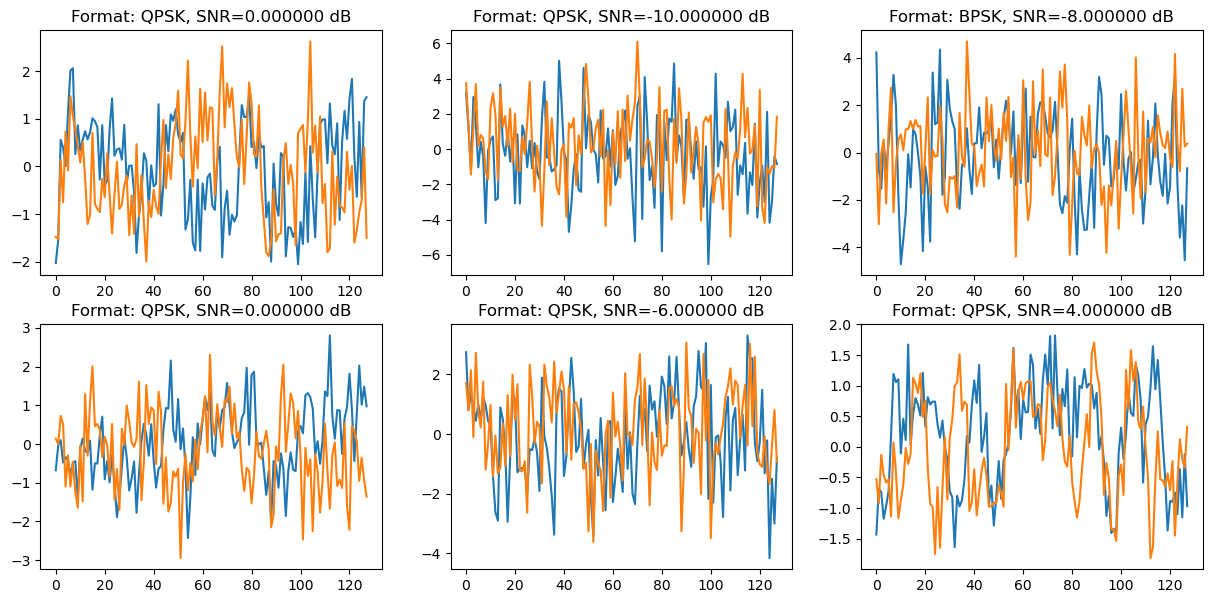

In [8]:
starti = np.random.randint(0,X_train_task_1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task_1[k+starti,:]))
    plt.plot(np.imag(X_train_task_1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats_task_1[y_train_task_1[k+starti]], SNR_train_task_1[k+starti]))    

In [9]:
# prepare data, convert complex data to real and imaginary parts
X_train_task_1_real = np.column_stack((np.real(X_train_task_1), np.imag(X_train_task_1)))
X_valid_task_1_real = np.column_stack((np.real(X_valid_task_1), np.imag(X_valid_task_1)))

#### Solution using learned binary classification

Here, we employ a binary classification to carry out the classification between BPSK and QPSK, similarly to what we have seen in the lecture for BPSK detection.

We define a feature vector $\boldsymbol{x} \in \mathbb{R}^2$ that contains the energy in the real and imaginary part of the signal trace:
\begin{equation*}
 \boldsymbol{x} = \begin{pmatrix}
 \sum_{i=1}^N (\mathrm{Re}\{r_i\})^2 \\ \sum_{i=1}^N (\mathrm{Im}\{r_i\})^2
 \end{pmatrix}
\end{equation*}

We use binary classification and define the probability $P(Y = 1 |\boldsymbol{\theta}, \boldsymbol{x}) = \sigma(\boldsymbol{\theta}^\top\boldsymbol{x})$.

If $P(Y = 1 |\boldsymbol{\theta}, \boldsymbol{x}) > \frac{1}{2}$, we decide for $Y = 1$ (QPSK).

The weight vector $\boldsymbol{\theta}$ is obtained as detailed in the lecture.

In [10]:
# prepare data, generate feature vector X consisting of energy of real part and enery of imaginary part
X_train_feature = np.column_stack( (np.sum(np.square(np.real(X_train_task_1)),1), np.sum(np.square(np.imag(X_train_task_1)),1)) )
X_valid_feature = np.column_stack( (np.sum(np.square(np.real(X_valid_task_1)),1), np.sum(np.square(np.imag(X_valid_task_1)),1)) )

Stuff needed for logistic regression: 
* sigmoid function $\sigma(x) = \frac{1}{1+\exp(-x)}$
* the logistic prediction function $\sigma(\boldsymbol{\theta}^\mathsf{T}\boldsymbol{x})$
* the loss function $-\sum_{i=1}^N y_i^{[\textsf{train}]}\log(\sigma(\boldsymbol{\theta}^\mathsf{T}\boldsymbol{x}_i^{[\textsf{train}]}))+(1-y_i^{[\textsf{train}]})\log(1-\sigma(\boldsymbol{\theta}^\mathsf{T}\boldsymbol{x}_i^{[\textsf{train}]}))$
* the gradient of the loss function $\sum_{i=1}^N(\sigma(\boldsymbol{\theta}^\mathsf{T}\boldsymbol{x}_i^{[\textsf{train}]})-y_i^{[\textsf{train}]})\boldsymbol{x}_i^{[\textsf{train}]}$

In [11]:
# sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x,-600,600)))    # clip input values to avoid numerical overflow (inf)

def logistic_prediction(x, theta):
    return sigmoid(np.dot(x,theta))

def training_loss(weights):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_prediction(X_train_feature, weights)
    # add small epsilon of 0.0000000001 to avoid log(0)
    label_logits = np.log(preds + 0.0000000000001) * y_train_task_1 + np.log(1 - preds  + 0.0000000000001) * (1 - y_train_task_1)
    return -np.mean(label_logits)

# Function that computes the gradient 'by hand', i.e., by carrying out the maths as done in Tutorial 2
def training_gradient_handcalculated(weights):
    preds = logistic_prediction(X_train_feature, weights)
    grad_1 = np.mean((preds - y_train_task_1) * X_train_feature[:,0]);
    grad_2 = np.mean((preds - y_train_task_1) * X_train_feature[:,1]);
    return np.array([grad_1, grad_2])    

Carry out the training using simple gradient descent

In [12]:
weights = np.array([0.0, 0.0])
print("Initial loss:", training_loss(weights))
preds = logistic_prediction(X_train_feature, weights) > 0.5
for i in range(500):            
    if i % 100 == 0:
        preds = logistic_prediction(X_train_feature, weights) > 0.5
        errors = np.sum(preds != y_train_task_1)        
        print('Step',i,' : ',errors,' errors with loss ',training_loss(weights))    
    weights -= training_gradient_handcalculated(weights) * 0.01
    
print("Trained loss:", training_loss(weights))

print(weights)

Initial loss: 0.6931471805597462
Step 0  :  319851  errors with loss  0.6931471805597462
Step 100  :  85451  errors with loss  3.811007420998402
Step 200  :  85236  errors with loss  3.8002559507196265
Step 300  :  85235  errors with loss  3.800231423986259
Step 400  :  85235  errors with loss  3.800231363713342
Trained loss: 3.800231363571178
[-2.86514094  4.11676467]


In [13]:
print("Example:")
idx = 12
print("Feature vector: ", X_train_feature[idx,:])
print("Corresponds to %s at an SNR of %1.2f dB" % (modulation_formats_task_1[y_train_task_1[idx]], SNR_train_task_1[idx]))
print("Output of estimator: P(Y = 1|\\theta, x) = %1.2f" % logistic_prediction(X_train_feature[idx,:], weights))

Example:
Feature vector:  [761.4011 691.1356]
Corresponds to QPSK at an SNR of -10.00 dB
Output of estimator: P(Y = 1|\theta, x) = 1.00


We can relate this learned binary classifier to the very simple rule-based classifier from the first example. The classifier is based on the fact that for BPSK, almost all the energy of a signal is contained in the inphase-component (the real part) while the imaginary part contains only noise. We compare the powers of inphase and quadrature components by calculating the ratio
$$
F = \frac{\sum_{i=1}^N (\mathrm{Re}\{r_i\})^2}{\sum_{i=1}^N (\mathrm{Im}\{r_i\})^2} = \frac{x_1}{x_2}
$$
We classify the signal as BPSK if $F > C$, i.e., and the constant is obtained from the coefficients of the logistic regression as $-\frac{\theta_2}{\theta_1}$. This can be seen as follows:

With our proposed classifier, we classify as BPSK if $\sigma(\boldsymbol{\theta}^\mathsf{T}\boldsymbol{x}) < \frac{1}{2}$ which is equivalent to (by the definition of $\sigma(\cdot)$) $\boldsymbol{\theta}^\mathsf{T}\boldsymbol{x} < 0$, i.e., $\theta_1x_1 + \theta_2 x_2 < 0$. Rearranging leads to $\theta_1x_1 < -\theta_2x_2$ and hence, in case $\theta_1 < 0$ (which can be verified), $F = \frac{x_1}{x_2} > -\frac{\theta_2}{\theta_1}$

In [14]:
print("We classify the signal as QPSK if %1.2f * x_1 + %1.2f * x_2 > 0" % (weights[0], weights[1]))
print("Equivalently, we classify the signal as QPSK if F < %1.2f" % (-weights[1]/weights[0]))
print("Equivalently, we classify the signal as BPSK if F > %1.2f" % (-weights[1]/weights[0]))

We classify the signal as QPSK if -2.87 * x_1 + 4.12 * x_2 > 0
Equivalently, we classify the signal as QPSK if F < 1.44
Equivalently, we classify the signal as BPSK if F > 1.44


In [15]:
# This is the final classified using the learned weights
def BPSK_QPSK(data):  
    # use logistic regression to classifiy BPSK versus QPSK
    power_I = np.sum(np.square(np.real(data)), axis=1)
    power_Q = np.sum(np.square(np.imag(data)), axis=1)

    # Use the weights obtained earlier
    classification = logistic_prediction(np.column_stack((power_I, power_Q)), weights) > 0.5    
    return classification

In [16]:
# Validate results
idx_SNR_valid = []
for i in range(len(SNRs_task_1)):
    idx_SNR_valid.append(np.asarray(np.where(SNR_valid_task_1 == SNRs_task_1[i])))    

error_rates_single_SNR = np.empty([len(SNRs_task_1)])
for SNR in range(len(SNRs_task_1)):
   
    # Get data coresponding to the SNR value
    X_valid_single_SNR = X_valid_task_1[idx_SNR_valid[SNR]]
    y_valid_single_SNR = y_valid_task_1[idx_SNR_valid[SNR]]


    yh = BPSK_QPSK(X_valid_single_SNR.squeeze())
    error_rates_single_SNR[SNR] = CER(yh, y_valid_single_SNR)

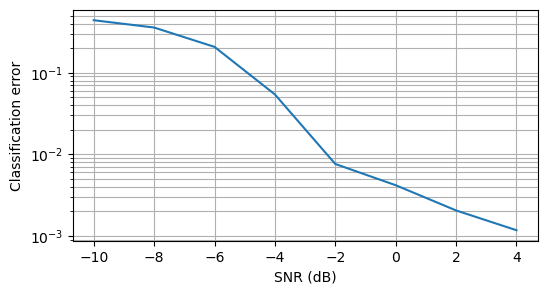

In [17]:
# Plot Results    
plt.figure(figsize=(6,3))
plt.semilogy(SNRs_task_1, error_rates_single_SNR)
plt.xlabel('SNR (dB)')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.savefig('Example_result.pdf',bbox_inches='tight')

In [18]:
# Send test data through the classifier
predictions_task_1 = BPSK_QPSK(X_test_task_1.squeeze())


# Write predictions to file including sanity check
### Don't touch this part
check_predictions(X_test_task_1, predictions_task_1, range(len(modulation_formats_task_1)))

with open('Task_1_%s.pkl' % team_name,'wb') as f:
    pickle.dump(predictions_task_1,f)

type ok.
dim ok.
length ok.
Predictions are valid values.
